## Author
- Name: Kok Gin Xian
- Email: xian_kgx@hotmail.com

# Deep Image Prior
This is a quick attempt to reproduce the work [Deep Image Prior](https://dmitryulyanov.github.io/deep_image_prior) for image denoising.  
  
## Summary
In brief, it says that you don't really need example pairs for certain tasks such as image denoising. What you can do is to use  the one image that you want to be processed (denoising, resized, etc.), fit a network to it, but don't fit it for too long.  
  
The idea is that it is harder to learn the **image contents plus noise** rather than just the **image contents** itself. In other words, there is **high impedance** towards learning noise. However, if we fit the network to the image long enough, eventually, the network will be able to overfit to the image and learn the noise provided there is enough capacity in the network to do so. The idea here is to stop training before that point is reached.

## Analysis
### Pros
1. Don't need dataset to perform task.
### Cons
1. Impractical for deployment as it can be slow to train a network with the input image everytime we need to do inference.

## References
1. [How To Perform Image Restoration Absolutely DataSet Free](https://towardsdatascience.com/how-to-perform-image-restoration-absolutely-dataset-free-d08da1a1e96d)
1. [Deep Image Prior](https://dmitryulyanov.github.io/deep_image_prior)

In [5]:
import numpy as np

import matplotlib.pyplot as plt

import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Input image

In [12]:
test_image = skimage.io.imread("egyptian-goose-noise.jpg")/np.float32(255)
test_image.shape

(199, 300, 3)

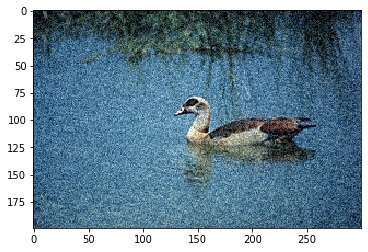

In [13]:
plt.imshow(test_image)

## Model

In [17]:
class DeepImagePrior(nn.Module):
    def __init__(self):
        super(DeepImagePrior, self).__init__()
        layers = []

        channels = 64

        layers.append(nn.Conv2d(3, channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())

        for _ in range(13):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(channels))
            layers.append(nn.ReLU())

        layers.append(nn.Conv2d(channels, 3, kernel_size=3, padding=1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [18]:
model = DeepImagePrior()

In [19]:
def fit(model, image, steps=20, lr=0.01):
    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    loss_fn = torch.nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    x = image.permute(0, 3, 1, 2)

    if torch.cuda.is_available():
        model = model.cuda()
        x = x.cuda()

    for t in range(steps):
        optimizer.zero_grad()

        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __call__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        y_pred = model(x)

        # Compute and print loss. We pass Tensors containing the predicted and true
        # values of y, and the loss function returns a Tensor containing the
        # loss.
        #         loss = ((y_pred - x) ** 2).sum((1, 2, 3)).mean()
        loss = loss_fn(y_pred, x)
        #         print("loss.shape:", loss.shape)
        print(t, loss.item())

        # Zero the gradients before running the backward pass.
        #         model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        optimizer.step()

    return model

In [20]:
out = model(torch.from_numpy(np.expand_dims(test_image, axis=0)).permute(0,3,1,2))

In [21]:
out.shape

torch.Size([1, 3, 199, 300])

In [22]:
out = np.squeeze(out.detach().permute(0,2,3,1).numpy())

In [23]:
out.shape, out

((199, 300, 3), array([[[0.4837144 , 0.5604443 , 0.51958966],
         [0.5153187 , 0.5395423 , 0.55890244],
         [0.41171288, 0.46538326, 0.47270086],
         ...,
         [0.5215376 , 0.5216253 , 0.59197325],
         [0.45253155, 0.50228536, 0.6101545 ],
         [0.52337426, 0.51163715, 0.5759059 ]],
 
        [[0.49256578, 0.59612644, 0.50527436],
         [0.4973087 , 0.53344446, 0.51744336],
         [0.42586362, 0.5479477 , 0.5997095 ],
         ...,
         [0.48914352, 0.5592345 , 0.57705516],
         [0.43408656, 0.49774387, 0.621145  ],
         [0.4937393 , 0.48395172, 0.59720874]],
 
        [[0.5105655 , 0.59133565, 0.5272251 ],
         [0.5412824 , 0.59534407, 0.54369605],
         [0.4817996 , 0.61173123, 0.49893916],
         ...,
         [0.38528213, 0.5613131 , 0.6026029 ],
         [0.47281116, 0.50058556, 0.5877962 ],
         [0.50356627, 0.47649625, 0.5206859 ]],
 
        ...,
 
        [[0.5040845 , 0.61159474, 0.54056567],
         [0.5036584 , 0.61

In [24]:
np.expand_dims(test_image, axis=0)

Array([[[[0.        , 0.01176471, 0.01176471],
         [0.15294118, 0.17254902, 0.18431373],
         [0.        , 0.        , 0.01960784],
         ...,
         [0.07450981, 0.16862746, 0.2627451 ],
         [0.3019608 , 0.36862746, 0.44705883],
         [0.09803922, 0.16078432, 0.22352941]],

        [[0.21568628, 0.23921569, 0.23921569],
         [0.10588235, 0.1254902 , 0.13725491],
         [0.05882353, 0.07058824, 0.09019608],
         ...,
         [0.20784314, 0.3019608 , 0.40392157],
         [0.00392157, 0.08627451, 0.16862746],
         [0.        , 0.07450981, 0.14117648]],

        [[0.        , 0.00784314, 0.01960784],
         [0.00392157, 0.02352941, 0.03529412],
         [0.        , 0.00392157, 0.02352941],
         ...,
         [0.2509804 , 0.35686275, 0.4627451 ],
         [0.20784314, 0.3019608 , 0.39607844],
         [0.05098039, 0.14901961, 0.23529412]],

        ...,

        [[0.16470589, 0.28235295, 0.3764706 ],
         [0.2509804 , 0.36862746, 0.4627451 ]

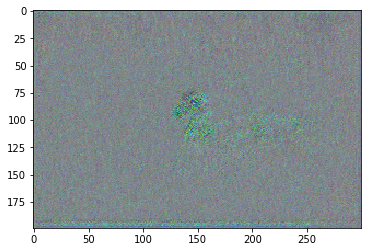

In [25]:
plt.imshow(out)

## Train model on input image

In [26]:
fit(model, torch.from_numpy(np.expand_dims(test_image, axis=0)), steps=2000, lr=0.01)

0 0.04643385112285614
1 0.045923493802547455
2 0.044971756637096405
3 0.04365932196378708
4 0.042068302631378174
5 0.040270138531923294
6 0.038315191864967346
7 0.03625313565135002
8 0.03415028378367424
9 0.03205728903412819
10 0.030016867443919182


KeyboardInterrupt: 

In [27]:
model = model.cpu()

## Denoise input image

In [28]:
predicted = model(torch.from_numpy(np.expand_dims(test_image, axis=0)).permute(0,3,1,2))

In [29]:
np.squeeze(predicted.detach().permute(0,2,3,1).numpy())

array([[[0.44768515, 0.5160299 , 0.5153805 ],
        [0.47326526, 0.5195502 , 0.46573034],
        [0.35586068, 0.37969342, 0.50386614],
        ...,
        [0.3921454 , 0.47360867, 0.52220154],
        [0.3970957 , 0.47165683, 0.58199364],
        [0.47055286, 0.5200243 , 0.6062988 ]],

       [[0.4615871 , 0.56360173, 0.4603217 ],
        [0.39036518, 0.4446124 , 0.45216253],
        [0.37942058, 0.51285046, 0.55776167],
        ...,
        [0.37685654, 0.5108007 , 0.4553477 ],
        [0.35189334, 0.4184726 , 0.59147424],
        [0.40018907, 0.3784664 , 0.6002432 ]],

       [[0.47234026, 0.53201103, 0.48799032],
        [0.49139956, 0.53154945, 0.4749762 ],
        [0.3079963 , 0.5157189 , 0.4972446 ],
        ...,
        [0.35159257, 0.46886668, 0.5215898 ],
        [0.35658965, 0.4347572 , 0.4999621 ],
        [0.40136066, 0.48950893, 0.5528435 ]],

       ...,

       [[0.40866813, 0.5974379 , 0.46688142],
        [0.44050038, 0.62256825, 0.5345237 ],
        [0.38796073, 0

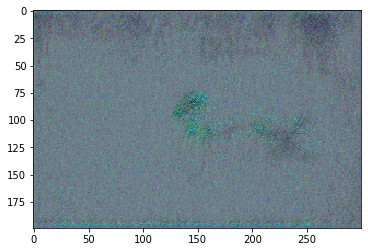

In [30]:
plt.imshow(np.squeeze(predicted.detach().permute(0,2,3,1).numpy()))